In [ ]:
# Core libraries
import os
import re
import pandas as pd
import numpy as np
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


# ML tools
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

# Deep Learning (Keras)
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# Google Drive (Colab-specific)
from google.colab import drive
drive.mount('/content/drive')

In [5]:
train = pd.read_csv('/content/drive/My Drive/FinalProject2/train_data.csv')
test = pd.read_csv('/content/drive/My Drive/FinalProject2/test_data.csv')

/tmp/ipython-input-5-3685922727.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/drive/My Drive/FinalProject2/train_data.csv')


In [6]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         838944 non-null  int64 
 1   vote            191468 non-null  object
 2   verified        838944 non-null  bool  
 3   reviewTime      838944 non-null  object
 4   reviewerID      838944 non-null  object
 5   asin            838944 non-null  object
 6   style           490613 non-null  object
 7   reviewerName    838717 non-null  object
 8   reviewText      838944 non-null  object
 9   summary         838868 non-null  object
 10  unixReviewTime  838944 non-null  int64 
dtypes: bool(1), int64(2), object(8)
memory usage: 64.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   vote            4933 non-null   float64


(None, None)

In [7]:
train.verified.value_counts()
df = train[train.verified].reset_index(drop=True).copy()

In [8]:
# Fill vote columns null with zrero and change to numeric
df.vote = df.vote.str.replace(',', '')
df.vote = pd.to_numeric(df.vote, errors='coerce')
df.fillna(0, inplace=True)


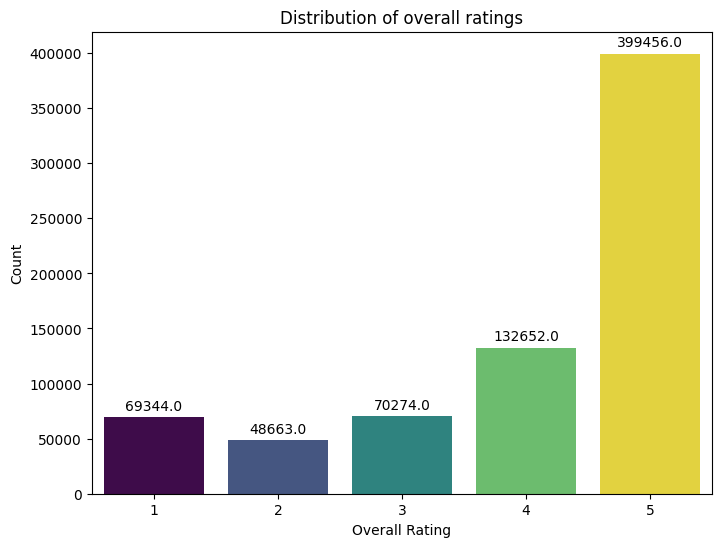

In [9]:
#P_1_1: Plot overall score distribution


plt.figure(figsize=(8, 6))
ax = sns.countplot(x='overall', hue='overall', data=df, palette='viridis',
                   legend=False)
plt.title('Distribution of overall ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black',
                xytext=(0, 3), textcoords='offset points')

plt.show();


In [10]:
# P_1_2: Split reviews into positive, neutral, negative

df['sentiment'] = df['overall'].map({
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
})

df['sentiment'].value_counts()

,count
sentiment,
positive,532108
negative,118007
neutral,70274


In [11]:
# Clean texts

def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

df['cleaned_text'] = df['reviewText'].apply(clean_text)
test['cleaned_text'] = test['reviewText'].apply(clean_text)

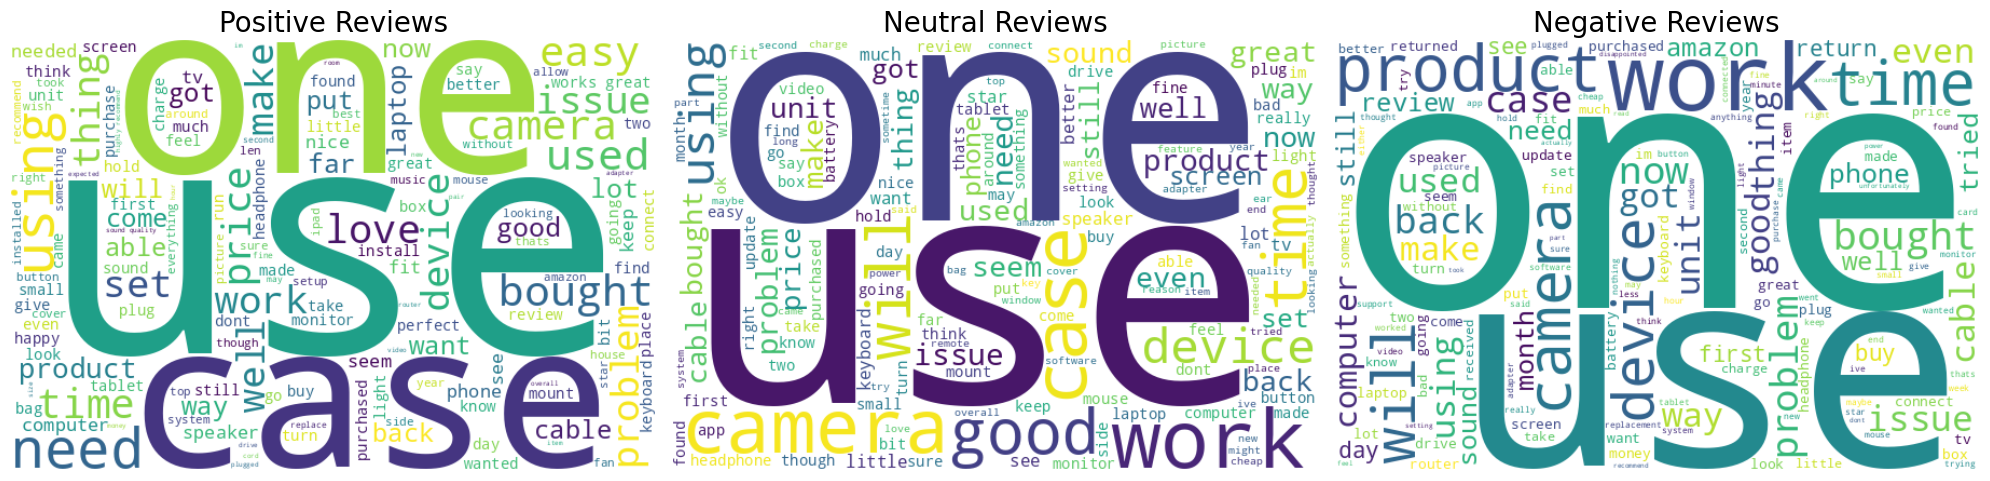

In [12]:
#P_1_3: Word Cloud Analysis by Sentiment Class

pos_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_text'].dropna().tolist())
neu_text = ' '.join(df[df['sentiment'] == 'neutral']['cleaned_text'].dropna().tolist())
neg_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned_text'].dropna().tolist())

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for ax, text, title in zip(axes, [pos_text, neu_text, neg_text], ['Positive', 'Neutral', 'Negative']):
    wc = WordCloud(width=600, height=400, background_color='white', max_words=150).generate(text)
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"{title} Reviews", fontsize=20)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# Get common words in positive, neutral & negative sentiments

stop_words = set(stopwords.words('english'))

def get_top_n_words(text, n):
    words = [w for w in text.split() if w not in stop_words and len(w) > 2]
    counter = Counter(words)
    return dict(counter.most_common(n))

top_pos = get_top_n_words(pos_text, 100)
top_neu = get_top_n_words(neu_text, 100)
top_neg = get_top_n_words(neg_text, 100)

common_words_all = set(top_pos.keys()) & set(top_neu.keys()) & set(top_neg.keys())

commons = {}
for word in common_words_all:
    if word in top_pos and top_neu and top_neg:
        commons[word] = (top_pos[word], top_neu[word], top_neg[word])

df_common =  pd.DataFrame.from_dict(commons).T
df_common.columns = ['freq_pos', 'freq_neu', 'freq_neg']
df_common.sort_values(by='freq_pos', ascending=False).head(10)

df_common.sort_index()

,freq_pos,freq_neu,freq_neg
also,105936,14833,20007
another,44877,7849,15563
around,50387,7172,9184
back,68274,13066,28016
battery,61854,9137,14728
...,...,...,...
without,55709,6139,9382
work,100513,21586,42590
worked,44057,6410,16751
works,134072,16348,16860


In [14]:
#P1_4: Top voters names and sum of votes

top_voters = df.groupby('reviewerID').agg(
    vote_sum=('vote', 'sum'),
    reviewer_name=('reviewerName', 'first')).sort_values(by='vote_sum', ascending=False).head(10)
top_voters[['reviewer_name', 'vote_sum']]

,reviewer_name,vote_sum
reviewerID,,
A25GROL6KJV3QG,Benson Leung,4345.0
A1KPFZCS71QKW5,nycebo,2978.0
A3KJ0DF3LTNJ6X,Voltron00x,2900.0
AMYCUX8EWEUVV,Mayra S.,1934.0
AW7UMXXJKFSNS,Sally B.,1912.0
A2VQ0V1TWXF3U7,Mark A. Baker,1820.0
A1BB1M0MBTRJ8I,Michele,1549.0
AW8VWBDVP31E5,Gromulus,1372.0
A9K7V1MKJ9BOJ,VermontGuy,1337.0


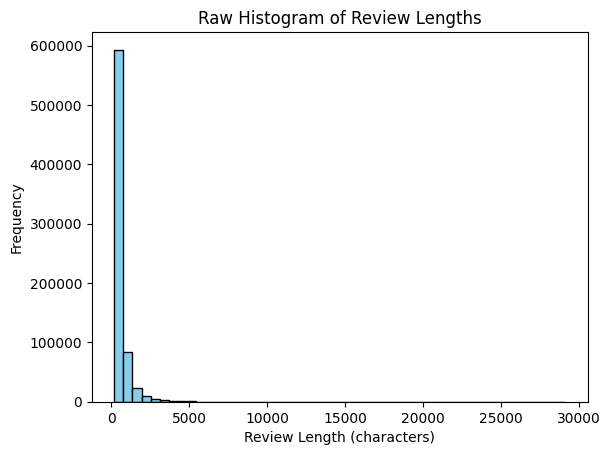

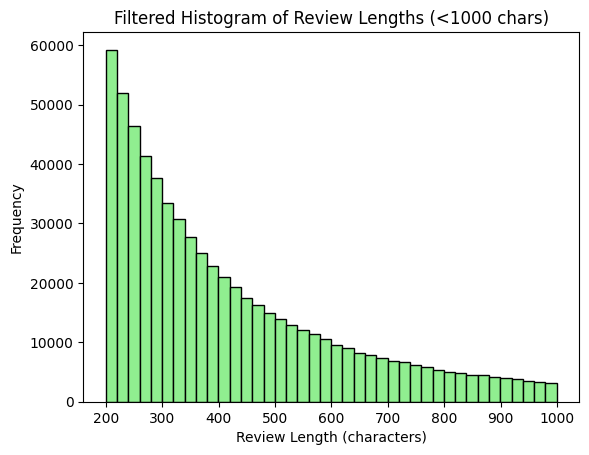

In [15]:
#P_1_4: Plot histogram of reviewText length (character count)

# Calculate number of characters in each review
df['review_length'] = df['reviewText'].apply(len)

# Plot raw histogram to observe full distribution
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Raw Histogram of Review Lengths')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Filter out extreme lengths (outliers) for cleaner visualization
filtered = df[df['review_length'] < 1000]  # adjust threshold as needed

# Plot histogram after filtering
plt.hist(filtered['review_length'], bins=40, color='lightgreen', edgecolor='black')
plt.title('Filtered Histogram of Review Lengths (<1000 chars)')
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.show()



In [16]:
#P_1_5: Find top 10 products with most 5-star reviews

title = pd.read_csv('/content/drive/My Drive/FinalProject2/title_brand.csv')

top_5_df = df[df['overall'] == 5]

product_5_counts = top_5_df.groupby('asin').size().reset_index(name='five_star_count')

product_5_with_info = product_5_counts.merge(title, on='asin', how='left')

top_10_products = product_5_with_info.sort_values(by='five_star_count', ascending=False).head(10)

top_10_products[['brand', 'five_star_count']]


,brand,five_star_count
48473,Cambridge Soundworks,1120
32987,NETGEAR,617
5874,StarTech,566
62706,Roku,542
37330,Samsung,516
10621,Logitech,511
41009,Asus,432
5987,VideoSecu,420
37297,Samsung,420
23113,Cheetah,398


In [17]:
#P_1_6: Find top 10 brands by number of reviews and show their average score

top_brands = df.groupby('asin')['overall'].mean().sort_values(ascending=False).head(10).reset_index()
top_brands_with_brand = top_brands.merge(title[['asin', 'brand']], on='asin', how='left')
top_brands_with_brand


,asin,overall,brand
0,1254875778,5.0,Dell
1,1061861740,5.0,SlimPort
2,B01HJH40WU,5.0,Jricoo
3,1060078031,5.0,Analogix Semiconductor
4,1059998254,5.0,Wireless Solutions
5,B01HJDR9DQ,5.0,GEILIENERGY
6,0594033926,5.0,Barnes &amp; Noble
7,1615527672,5.0,Barnes &amp; Noble
8,0594450268,5.0,Nook
9,0594459451,5.0,Barnes &amp; Noble


In [18]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.9 MB/s eta 0:00:00


In [19]:
#P_2: Extract product-specific satisfaction about warranty-related aspects


from rapidfuzz import fuzz

all_words = pos_text + ' ' + neg_text + ' ' + neu_text

keywords = [
    'warranty',
    'guarantee',
    'assurance',
    'pledge',
    'promise',
    'bond',
    'security',
    'commitment',
    'covenant',
    'undertaking',
    'surety',
    'contract',
    'guarantee certificate',
    'warranty agreement',
    'guarantee policy',
    'written promise',
    'guarantee document'
]
found = []

for word in all_words.split():
    for kw in keywords:
        if fuzz.ratio(word.lower().strip(), kw) >= 80:
          found.append(word.lower())
          break

print(set(found))


{'ccdsecurity', 'surrey', 'bond', 'bonder', 'counteracts', 'counteract', 'roomwise', 'warrantyreplacement', 'warrantywill', 'contac', 'gaurantee', 'lede', 'securityanti', 'offwarranty', 'understating', 'securityroot', 'underrating', 'warrantylife', 'contactsi', 'bondot', 'promisedno', 'warrantysome', 'specularity', 'bonded', 'contactor', 'securityman', 'tboned', 'segurity', 'warrantygee', 'beyond', 'contradicted', 'warrantywise', 'conteract', 'bondo', 'guaratee', 'poise', 'contant', 'contrast', 'contack', 'warrnty', 'promine', 'contray', 'boned', 'contractions', 'waranty', 'warenty', 'promiseda', 'abound', 'fledge', 'guaranteesso', 'waarranty', 'warrantymm', 'warrent', 'securtiy', 'contacts', 'contactd', 'guarantees', 'warrantry', 'sureit', 'mainsecurity', 'guaranteeone', 'securly', 'techwarranty', 'warrantythe', 'securityaa', 'subcontracts', 'warrantycool', 'procise', 'assurances', 'bornd', 'overcontract', 'survey', 'warrantyso', 'bonked', 'contast', 'guarnteed', 'assurant', 'hexsecur

In [20]:
keywords.extend(found)
keywords = list(set(keywords))

pattern = r'\b(?:' + '|'.join(re.escape(k.lower()) for k in keywords) + r')\b'

mask = df['reviewText'].str.lower().str.contains(pattern, regex=True, na=False)
warranty_reviews = df[mask]

avg_ratings = warranty_reviews.groupby('asin')['overall'].mean().reset_index().sort_values(by='overall', ascending=False)

result = avg_ratings.merge(title[['asin', 'brand']], on='asin', how='left')

result.head(10)

,asin,overall,brand
0,B00000J1TM,5.0,Belkin
1,B00000J1TM,5.0,Belkin
2,B000001ON0,5.0,Maxell
3,0594296420,5.0,Barnes &amp; Noble
4,B01HJDR9DQ,5.0,GEILIENERGY
5,059449771X,5.0,Barnes & Noble
6,9985609034,5.0,A Days Tech
7,9983891212,5.0,LASUS
8,1061861740,5.0,SlimPort
9,B00000K2YV,5.0,Midland


In [21]:
#P_3_1: Sentiment Prediction Model (Target: Overall Rating from 1 to 5)
# drop duplicates with overall == 5

print('before:', df.shape)
df_5 = df[df['overall'] == 5]
df_5 = df_5.drop_duplicates(subset='reviewText', keep='first')

df_rest = df[df['overall'] != 5]
df = pd.concat([df_rest, df_5], ignore_index=True)
print('after:', df.shape)

before: (720389, 14)
after: (704935, 14)


In [22]:
# Train, test split

df['label'] = df['overall'] - 1
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['reviewText'],
    df['label'],
    test_size=0.2,
    stratify=df['label'],
    random_state=42)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [23]:
texts = ['train_texts', 'val_texts', 'train_labels', 'val_labels']
for i in texts:
  print(i,'shape: ', eval(i).shape)

train_texts shape:  (563948,)
val_texts shape:  (140987,)
train_labels shape:  (563948,)
val_labels shape:  (140987,)


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight


def build_dataset(texts, labels=None, tokenizer=None, max_vocab_size=10000,
                  max_seq_len=128, shuffle=False, batch_size=128):

    if tokenizer is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
        tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)
    padded_seqs = tf.constant(
        pad_sequences(sequences, maxlen=max_seq_len, padding='post', truncating='post')
    )

    if labels is not None:
        labels = tf.convert_to_tensor(labels)
        dataset = tf.data.Dataset.from_tensor_slices((padded_seqs, labels))
    else:
        dataset = tf.data.Dataset.from_tensor_slices(padded_seqs)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(texts), reshuffle_each_iteration=True)

    dataset = dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, tokenizer


train_dataset, tokenizer = build_dataset(train_texts, train_labels, shuffle=True)
val_dataset, _ = build_dataset(val_texts, val_labels, tokenizer=tokenizer)
test_dataset, _ = build_dataset(test['reviewText'], tokenizer=tokenizer)



In [25]:
datasets = ['train_dataset', 'val_dataset', 'test_dataset']
for dataset in datasets:
  print(dataset, 'shape: ', eval(dataset))

train_dataset shape:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
val_dataset shape:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
test_dataset shape:  <_PrefetchDataset element_spec=TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)>


In [30]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

# Constants
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 128
EMBEDDING_DIM = 150  # Reduced for speed
NUM_CLASSES = 5

l2_reg = regularizers.l2(1e-4)

inputs = layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True)(inputs)
x = layers.SpatialDropout1D(0.2)(x)

# One GRU instead of stacked LSTM+GRU (faster)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3, kernel_regularizer=l2_reg))(x)

# Pooling
x_max = layers.GlobalMaxPooling1D()(x)
x_avg = layers.GlobalAveragePooling1D()(x)
x = layers.Concatenate()([x_max, x_avg])

# Dense + Regularization
x = layers.Dense(64, activation='relu', kernel_regularizer=l2_reg)(x)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer
outputs = layers.Dense(NUM_CLASSES)(x)  # Logits

# Build model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 128, 150)  │  1,500,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 128, 150)  │          0 │ embedding_2[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 128)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 128, 128)  │     82,944 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_4[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_4[… │
│ (GlobalAveragePool… │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     16,448 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64)        │        128 │ dense_4[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 5)         │        325 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,599,845 (6.10 MB)

 Trainable params: 1,599,845 (6.10 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from datetime import datetime

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint_path = os.path.join("checkpoints", "model.weights.h5")

tensorboard_cb = TensorBoard(log_dir=log_dir)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# === Train ===
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    # class_weight=class_weights,
    callbacks=[earlystop_cb, checkpoint_cb, tensorboard_cb]
)



Epoch 1/20
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6293 - loss: 0.9752
Epoch 1: val_loss improved from inf to 0.81214, saving model to checkpoints/model.weights.h5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 92s 20ms/step - accuracy: 0.6293 - loss: 0.9752 - val_accuracy: 0.6825 - val_loss: 0.8121
Epoch 2/20
4405/4406 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6871 - loss: 0.8033
Epoch 2: val_loss improved from 0.81214 to 0.78370, saving model to checkpoints/model.weights.h5
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 91s 21ms/step - accuracy: 0.6871 - loss: 0.8033 - val_accuracy: 0.6951 - val_loss: 0.7837
Epoch 3/20
4405/4406 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7007 - loss: 0.7671
Epoch 3: val_loss did not improve from 0.78370
4406/4406 ━━━━━━━━━━━━━━━━━━━━ 87s 20ms/step - accuracy: 0.7007 - loss: 0.7671 - val_accuracy: 0.6945 - val_loss: 0.7947
Epoch 4/20
4405/4406 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7111 - loss: 0.7392
Epoch 4: val_loss improved from 0.78370 to 0

In [33]:
model.save('/content/drive/My Drive/FinalProject2/model1.h5')
preds = model.predict(test_dataset)
predicted_classes = tf.argmax(preds, axis=1).numpy()
predicted_classes += 1
submission_df = pd.DataFrame({'predicted': predicted_classes})
submission_df.to_csv('/content/drive/My Drive/FinalProject2/q2_submission.csv', index=False)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [34]:
from sklearn.metrics import f1_score

preds = model.predict(val_dataset)
predicted_classes = tf.argmax(preds, axis=1).numpy()
# predicted_classes += 1
f1 = f1_score(val_labels, predicted_classes, average='weighted')
print(f"F1 Score: {f1}")

1102/1102 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
F1 Score: 0.6979354612078313
